# use a subset of trials (ie, first 40) and see how well can decode across sessions

In [1]:
### from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_across_combined_trial_subset_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [7]:
#all_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93'
#expo_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#pre_animals =  'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#post_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#renew_animals ='c3f3','c3f2','c3m1', 'c3m2', 'c4m3',         'c10m8', '90', '91', '92','93'
#ext2_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'
#ext1_animals = 'c3f3','c3f2','c3m1', 'c3m2', 'c4m3', 'c4m4', 'c10m8', '90', '91', '92','93'

all_animals  = np.loadtxt('../allmice.txt', dtype=str)
expo_animals = np.loadtxt('../expo_mice.txt', dtype=str)
pre_animals  = np.loadtxt('../pre_mice.txt', dtype=str)
post_animals = np.loadtxt('../post_mice.txt', dtype=str)
renew_animals= np.loadtxt('../renew_mice.txt', dtype=str)
ext2_animals = np.loadtxt('../ext2_mice.txt', dtype=str)
ext1_animals = np.loadtxt('../ext1_mice.txt', dtype=str)

In [8]:
#find animals common to both sessions
expopre_animals = np.intersect1d(expo_animals, pre_animals)
expopost_animals = np.intersect1d(expo_animals, post_animals)
prepost_animals = np.intersect1d(pre_animals, post_animals)
preext1_animals = np.intersect1d(pre_animals, ext1_animals)
preext2_animals = np.intersect1d(pre_animals, ext2_animals)
prerenew_animals = np.intersect1d(pre_animals, renew_animals)
postext1_animals = np.intersect1d(post_animals, ext1_animals)
postext2_animals = np.intersect1d(post_animals, ext2_animals)
postrenew_animals = np.intersect1d(post_animals, renew_animals)
ext1ext2_animals = np.intersect1d(ext1_animals, ext2_animals)
ext1renew_animals = np.intersect1d(ext1_animals, renew_animals)
ext2renew_animals = np.intersect1d(ext2_animals, renew_animals)

In [9]:
sessions = 'expo', 'pre', 'post', 'ext1', 'ext2', 'renew'

In [10]:
for sess in 'pre', 'post', 'ext1', 'ext2', 'renew':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [11]:
#have to extract 2_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/2_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [12]:
delta_t0 = 1

t_start0 = -5  # sec
t_stop0 = 11  # sec

In [13]:
#get patterns of CellReg'd cells
expopre_patterns_expo_first30 = load_all_animals_vars('patterns_evs_expopre', expopre_animals, '', notebook='decoding_expoVSpre_30trials')          
expopre_patterns_pre_first30 = load_all_animals_vars('patterns_evs_pre_first30', expopre_animals, '', notebook='decoding_expoVSpre_30trials')                                            
expopre_labels_expo_first30 = load_all_animals_vars('labels_expo',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
expopre_labels_pre_first30 = load_all_animals_vars('labels_pre_first30',expopre_animals, '', notebook='decoding_expoVSpre_30trials')
prepost_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_post', prepost_animals, '', notebook='patterns_time_bins')             
prepost_patterns_post = load_all_animals_vars('patterns_evs_1s_post_pre', prepost_animals, '', notebook='patterns_time_bins')
prepost_labels_pre = load_all_animals_vars('labels_pre',prepost_animals, '', notebook='patterns_time_bins')
prepost_labels_post = load_all_animals_vars('labels_post',prepost_animals, '', notebook='patterns_time_bins')
preext1_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext1', preext1_animals, '', notebook='patterns_time_bins')             
preext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_pre', preext1_animals, '', notebook='patterns_time_bins')
preext1_labels_pre = load_all_animals_vars('labels_pre',preext1_animals, '', notebook='patterns_time_bins')
preext1_labels_ext1 = load_all_animals_vars('labels_ext1',preext1_animals, '', notebook='patterns_time_bins')
preext2_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_ext2', preext2_animals, '', notebook='patterns_time_bins')             
preext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_pre', preext2_animals, '', notebook='patterns_time_bins')
preext2_labels_pre = load_all_animals_vars('labels_pre',preext2_animals, '', notebook='patterns_time_bins')
preext2_labels_ext2 = load_all_animals_vars('labels_ext2',preext2_animals, '', notebook='patterns_time_bins')
prerenew_patterns_pre = load_all_animals_vars('patterns_evs_1s_pre_renew', prerenew_animals, '', notebook='patterns_time_bins')             
prerenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_pre', prerenew_animals, '', notebook='patterns_time_bins')
prerenew_labels_pre = load_all_animals_vars('labels_pre',prerenew_animals, '', notebook='patterns_time_bins')
prerenew_labels_renew = load_all_animals_vars('labels_renew',prerenew_animals, '', notebook='patterns_time_bins')
postext1_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext1',postext1_animals, '', notebook='patterns_time_bins')
postext1_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_post',postext1_animals, '', notebook='patterns_time_bins')
postext1_labels_post = load_all_animals_vars('labels_post',postext1_animals, '', notebook='patterns_time_bins')
postext1_labels_ext1 = load_all_animals_vars('labels_ext1',postext1_animals, '', notebook='patterns_time_bins')
postext2_patterns_post = load_all_animals_vars('patterns_evs_1s_post_ext2',postext2_animals, '', notebook='patterns_time_bins')
postext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_post',postext2_animals, '', notebook='patterns_time_bins')
postext2_labels_post = load_all_animals_vars('labels_post',postext2_animals, '', notebook='patterns_time_bins')
postext2_labels_ext2 = load_all_animals_vars('labels_ext2',postext2_animals, '', notebook='patterns_time_bins')
postrenew_patterns_post = load_all_animals_vars('patterns_evs_1s_post_renew',postrenew_animals, '', notebook='patterns_time_bins')
postrenew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_post',postrenew_animals, '', notebook='patterns_time_bins')
postrenew_labels_post = load_all_animals_vars('labels_post',postrenew_animals, '', notebook='patterns_time_bins')
postrenew_labels_renew = load_all_animals_vars('labels_renew',postrenew_animals, '', notebook='patterns_time_bins')
ext1ext2_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_ext2', ext1ext2_animals, '', notebook='patterns_time_bins')             
ext1ext2_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_ext1', ext1ext2_animals, '', notebook='patterns_time_bins')
ext1ext2_labels_ext1 = load_all_animals_vars('labels_ext1',ext1ext2_animals, '', notebook='patterns_time_bins')
ext1ext2_labels_ext2 = load_all_animals_vars('labels_ext2',ext1ext2_animals, '', notebook='patterns_time_bins')
ext1renew_patterns_ext1 = load_all_animals_vars('patterns_evs_1s_ext1_renew', ext1renew_animals, '', notebook='patterns_time_bins')             
ext1renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext1', ext1renew_animals, '', notebook='patterns_time_bins')
ext1renew_labels_ext1 = load_all_animals_vars('labels_ext1',ext1renew_animals, '', notebook='patterns_time_bins')
ext1renew_labels_renew = load_all_animals_vars('labels_renew',ext1renew_animals, '', notebook='patterns_time_bins')
ext2renew_patterns_renew = load_all_animals_vars('patterns_evs_1s_renew_ext2',ext2renew_animals, '', notebook='patterns_time_bins')
ext2renew_patterns_ext2 = load_all_animals_vars('patterns_evs_1s_ext2_renew',ext2renew_animals, '', notebook='patterns_time_bins')
ext2renew_labels_renew = load_all_animals_vars('labels_renew',ext2renew_animals, '', notebook='patterns_time_bins')
ext2renew_labels_ext2 = load_all_animals_vars('labels_ext2',ext2renew_animals, '', notebook='patterns_time_bins')


In [14]:
all_comparisons = 'prepost_patterns_pre',\
'prepost_patterns_post',\
'preext1_patterns_pre',\
'preext1_patterns_ext1',\
'preext2_patterns_pre',\
'preext2_patterns_ext2',\
'prerenew_patterns_pre',\
'prerenew_patterns_renew',\
'postext1_patterns_post',\
'postext1_patterns_ext1',\
'postext2_patterns_post',\
'postext2_patterns_ext2',\
'postrenew_patterns_post',\
'postrenew_patterns_renew',\
'ext1ext2_patterns_ext1',\
'ext1ext2_patterns_ext2',\
'ext1renew_patterns_ext1',\
'ext1renew_patterns_renew',\
'ext2renew_patterns_renew',\
'ext2renew_patterns_ext2'

In [16]:
#ani_comparisons = 'expopre','expopost','prepost','preext1','preext2','prerenew','postext1','postext2','postrenew','ext1ext2','ext1renew','ext2renew'
for comp in all_comparisons:
    for t in range(len(patterns_tb_pre['90'])):
        exec("%s_tb_%s = {}"%(comp,t))
        for ani in eval('%s_animals'%comp.split('_')[0]):
            try:
                print comp.split('_')[0],
                print ani,
                print t,
                exec("%s_tb_%s['%s'] = %s['%s'][%s]"%(comp,t,ani,comp,ani,t))
            except IOError as error:
                print 'ERROR'
            continue

prepost 90 0 prepost 91 0 prepost 92 0 prepost 93 0 prepost c10m8 0 prepost c3f2 0 prepost c3f3 0 prepost c3m1 0 prepost c3m2 0 prepost c4m3 0 prepost c4m4 0 prepost 90 1 prepost 91 1 prepost 92 1 prepost 93 1 prepost c10m8 1 prepost c3f2 1 prepost c3f3 1 prepost c3m1 1 prepost c3m2 1 prepost c4m3 1 prepost c4m4 1 prepost 90 2 prepost 91 2 prepost 92 2 prepost 93 2 prepost c10m8 2 prepost c3f2 2 prepost c3f3 2 prepost c3m1 2 prepost c3m2 2 prepost c4m3 2 prepost c4m4 2 prepost 90 3 prepost 91 3 prepost 92 3 prepost 93 3 prepost c10m8 3 prepost c3f2 3 prepost c3f3 3 prepost c3m1 3 prepost c3m2 3 prepost c4m3 3 prepost c4m4 3 prepost 90 4 prepost 91 4 prepost 92 4 prepost 93 4 prepost c10m8 4 prepost c3f2 4 prepost c3f3 4 prepost c3m1 4 prepost c3m2 4 prepost c4m3 4 prepost c4m4 4 prepost 90 5 prepost 91 5 prepost 92 5 prepost 93 5 prepost c10m8 5 prepost c3f2 5 prepost c3f3 5 prepost c3m1 5 prepost c3m2 5 prepost c4m3 5 prepost c4m4 5 prepost 90 6 prepost 91 6 prepost 92 6 prepost 93 6 

# set whether you want to use all cells, downsample to min cells for each compared session, or dowsample to global minimum of cells across all comparisons

In [17]:
#set downsampling parameter to:
#max_cells = all cells
#intraregion_min = downsample to the comparison with fewest cells within the same hippo region
#interregion_min = downsample to the comparison with fewest cells, considering both hippo regions
#gmin = the global minimum (pretty much corresponds to interregion_min)

downsample = 200

In [18]:
if downsample == 'max_cells':
    n_cells = None #will use all registered cells
if downsample == 'intraregion_min':
    n_cells = ut.load_variable('n_cells_across_min_vhpc', '../notebooks/autorestore/n_cells/')
if downsample == 'interregion_min':
    n_cells = ut.load_variable('n_cells_across_min_overall', '../notebooks/autorestore/n_cells/')
if downsample == 'gmin':
    n_cells = ut.load_variable('n_cells_gmin', '../notebooks/autorestore/n_cells/')
if downsample == 200:
    n_cells = 200

In [19]:
n_cells

200

In [21]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_within(patterns, labels, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)
#    cv =LeaveOneOut()
    
    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_train_a = np.random.permutation(np.where(labels[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    patterns_T = patterns.copy()
    labels_T = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
        patterns_T[ani] = patterns[ani][which_test[ani]]
        labels_T[ani] = labels[ani][which_test[ani]]
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [22]:
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
#     which_train = range(90)
#     which_test = range(90)

    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_t, labels_t)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_T, labels_T)
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

# take subset of trials

In [23]:
start_trials = [0,80]    # which trial do you want to start with?
end_trials = [40,120]     # which u wanna end with?
for comp in all_comparisons: # for each cross-session pattern data set
    for tb in range(16):  # for each time bin
        for start_trial,end_trial in zip(start_trials, end_trials):
            exec("S%s_E%s_%s_tb_%s = {}"%(start_trial,end_trial,comp,tb))  # initialize the patterns variable
            exec("S%s_E%s_%s_labels_%s = {}"%(start_trial,end_trial,comp.split('_')[0],comp.split('_')[-1]))  # initialize the labels variable
            for ani in eval("%s_animals"%comp.split('_')[0]):  # for each animal in the cross-session dataset
                exec("S%s_E%s_%s_tb_%s[ani] = %s_tb_%s[ani][start_trial:end_trial]"%(start_trial,end_trial,comp,tb,comp,tb))
                exec("S%s_E%s_%s_labels_%s[ani] = labels_%s[ani][start_trial:end_trial]"%(start_trial,end_trial,comp.split('_')[0],
                                               comp.split('_')[-1],comp.split('_')[-1]))

In [25]:
%%time
#test across (and within) time bins within a session
#need to overwrite within tb comparisons later, because here it uses same data to train & test
n_loops=20
for s,e in zip(start_trials,end_trials):
    for comp in all_comparisons:
        for t in range (16):
            for c in range (16):
                exec('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s = {}'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c))
                exec('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s = np.r_[[do_test_cross(S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,n_cells=n_cells)\
                for r in range(n_loops)]]'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c,
                                            s,e,comp,t,s,e,comp.split('_')[0],comp.split('_')[-1],s,e,comp,c,s,e,comp.split('_')[0],comp.split('_')[-1]))
        print '%s DONE!'%comp

prepost_patterns_pre DONE!
prepost_patterns_post DONE!
preext1_patterns_pre DONE!
preext1_patterns_ext1 DONE!
preext2_patterns_pre DONE!
preext2_patterns_ext2 DONE!
prerenew_patterns_pre DONE!
prerenew_patterns_renew DONE!
postext1_patterns_post DONE!
postext1_patterns_ext1 DONE!
postext2_patterns_post DONE!
postext2_patterns_ext2 DONE!
postrenew_patterns_post DONE!
postrenew_patterns_renew DONE!
ext1ext2_patterns_ext1 DONE!
ext1ext2_patterns_ext2 DONE!
ext1renew_patterns_ext1 DONE!
ext1renew_patterns_renew DONE!
ext2renew_patterns_renew DONE!
ext2renew_patterns_ext2 DONE!
prepost_patterns_pre DONE!
prepost_patterns_post DONE!
preext1_patterns_pre DONE!
preext1_patterns_ext1 DONE!
preext2_patterns_pre DONE!
preext2_patterns_ext2 DONE!
prerenew_patterns_pre DONE!
prerenew_patterns_renew DONE!
postext1_patterns_post DONE!
postext1_patterns_ext1 DONE!
postext2_patterns_post DONE!
postext2_patterns_ext2 DONE!
postrenew_patterns_post DONE!
postrenew_patterns_renew DONE!
ext1ext2_patterns_ex

In [26]:
%%time
#test across (and within) time bins within a session
#need to overwrite within tb comparisons later, because here it uses same data to train & test
n_loops=20
for s,e in zip(start_trials,end_trials):
    for comp in all_comparisons:
        for t in range (16):
            #for c in range (16):
                exec('S%s_E%s_scores_win_%s_%s_tb%s_VS_%s_%s_tb%s = {}'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],t))
                exec('S%s_E%s_scores_win_%s_%s_tb%s_VS_%s_%s_tb%s = np.r_[[do_test_within(S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,n_cells=n_cells)\
                for r in range(n_loops)]]'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],t,
                                            s,e,comp,t,s,e,comp.split('_')[0],comp.split('_')[-1]))


CPU times: user 10min 22s, sys: 692 ms, total: 10min 23s
Wall time: 10min 22s


In [27]:
%%time
#test across session pairs
n_loops=20
for s,e in zip(start_trials,end_trials):
    AC = all_comparisons
    for i in range(0,len(AC),2):
        for t in range (16):
            for c in range (16):
                exec('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s = {}'%(s,e,AC[i].split('_')[0],AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c))
                exec('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s = np.r_[[do_test_cross(S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,n_cells=n_cells)\
                for r in range(n_loops)]]'%(s,e,AC[i].split('_')[0],AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c,
                                            s,e,AC[i],t,s,e,AC[i].split('_')[0],AC[i].split('_')[-1],s,e,AC[i+1],c,s,e,AC[i+1].split('_')[0],AC[i+1].split('_')[-1]))

CPU times: user 1h 39min 16s, sys: 6.33 s, total: 1h 39min 22s
Wall time: 1h 39min 15s


In [29]:
# for each time bin, collect scores from diff comparisons into a single dictionary
for t in range (16):
    for s,e in zip(start_trials,end_trials):
        exec('S%s_E%s_testy%s = {}'%(s,e,t))
    
for i in range(0,len(AC),2):
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_testy%s['%s_%s_%s'] = []"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_testy%s['%s_%s_%s']"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1])).insert(c,(eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,AC[i].split('_')[0],
                            AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c))))

for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_testy%s['%s_%s_%s'] = []"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_testy%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1])).insert(c,(eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,comp.split('_')[0],
                            comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c))))

In [30]:
#and now replace within-session score from above with score where test and train data are taken from different bins
for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            eval("S%s_E%s_testy%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],
                                    comp.split('_')[-1]))[t] = eval('S%s_E%s_scores_win_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,comp.split('_')[0],
                                    comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],t))

In [31]:
#now put all time bins into a single dict
for s,e in zip(start_trials,end_trials):
    exec("S%s_E%s_testy={}"%(s,e))
    for i in eval("S%s_E%s_testy0"%(s,e)):
        exec("S%s_E%s_testy[i]=[]"%(s,e,))
        for r in range(len(eval("S%s_E%s_testy0[i]"%(s,e)))):
            exec("S%s_E%s_testy[i].append(S%s_E%s_testy%s[i])"%(s,e,s,e,r))
        exec("np.array([S%s_E%s_testy[i]])"%(s,e))

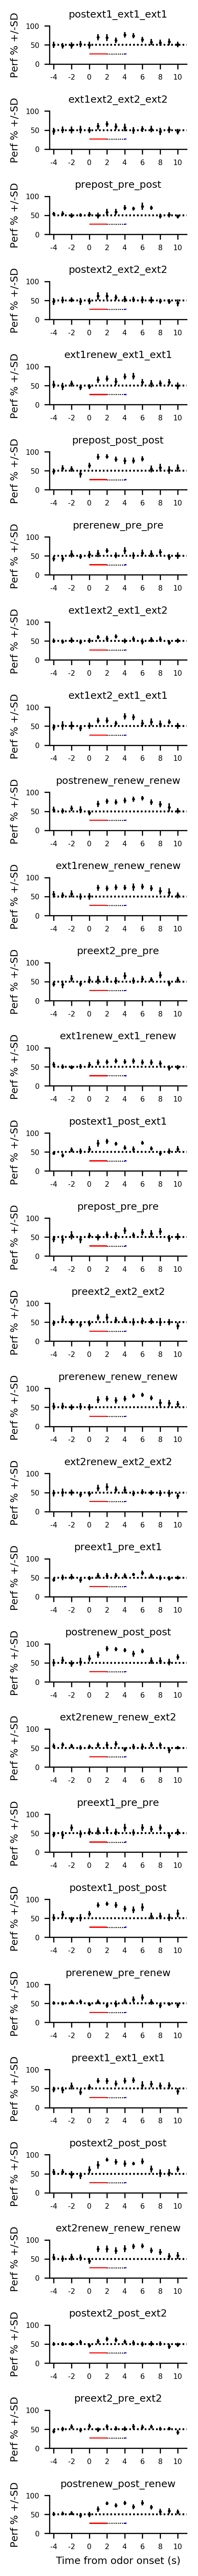

In [32]:
fig, ax = pl.subplots(len(S0_E40_testy),1, figsize=(2, 25))

for i,t in zip(range(len(S0_E40_testy)),S0_E40_testy):
    for r in range(16):
        ax[i].plot(r-5, np.mean(S0_E40_testy[t][r][r])*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(S0_E40_testy[t][r][r])*100
        s = np.std(S0_E40_testy[t][r][r])*100
        ax[i].errorbar(r-5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[i].set_ylim(0, 100)
        ax[i].set_xlim(-4.5, 11)
        ax[i].set_xticks(np.arange(-4,11, 2))
        ax[i].set_xticklabels(np.arange(-4,11, 2))
        ax[i].hlines(50, -4,11, color='k', lw=1, linestyles='dotted')
        ax[i].set_ylabel('Perf % +/-SD')
        pt.plot_period_bar(ax[i], 25, start_end=(0, 2), color='r', delta_y=3)
        # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[i], 25, start_end=(4, 4.2), color='b', delta_y=3)
        ax[i].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[i].set_title(t)
ax[i].set_xlabel('Time from odor onset (s)')


fig.tight_layout(pad=2)

#fig.savefig('../img/%s_gmin.jpg'%NOTEBOOK_NAME)

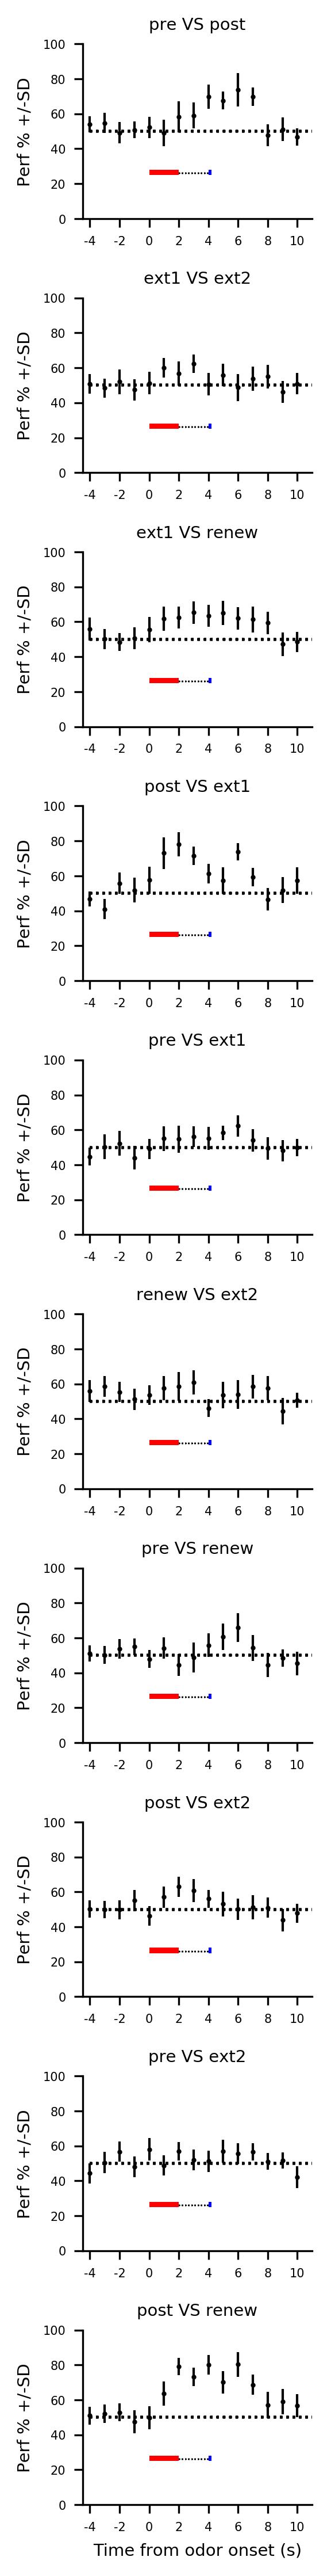

In [33]:
#across session only
fig, ax = pl.subplots(10,1, figsize=(2, 15))
across=[]
for x in [2,7,12,13,18,20,23,27,28,29]:
    across.append(eval("S%s_E%s_testy.keys()[x]"%('0','40')))
for i,t in zip(range(len(across)),across):
    for r in range(16):
        ax[i].plot(r-5, np.mean(eval("S%s_E%s_testy[t][r][r]"%('0','40')))*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(eval("S%s_E%s_testy[t][r][r]"%('0','40')))*100
        s = np.std(eval("S%s_E%s_testy[t][r][r]"%('0','40')))*100
        ax[i].errorbar(r-5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[i].set_ylim(0, 100)
        ax[i].set_xlim(-4.5, 11)
        ax[i].set_xticks(np.arange(-4,11, 2))
        ax[i].set_xticklabels(np.arange(-4,11, 2))
        ax[i].hlines(50, -4,11, color='k', lw=1, linestyles='dotted')
        ax[i].set_ylabel('Perf % +/-SD')
        pt.plot_period_bar(ax[i], 25, start_end=(0, 2), color='r', delta_y=3)
        # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[i], 25, start_end=(4, 4.2), color='b', delta_y=3)
        ax[i].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[i].set_title((t.split("_")[-2])+" VS "+(t.split("_")[-1]))
ax[i].set_xlabel('Time from odor onset (s)')


fig.tight_layout(pad=2)

fig.savefig('../img/%s_across_tb_matched_trials0-40.jpg'%NOTEBOOK_NAME)

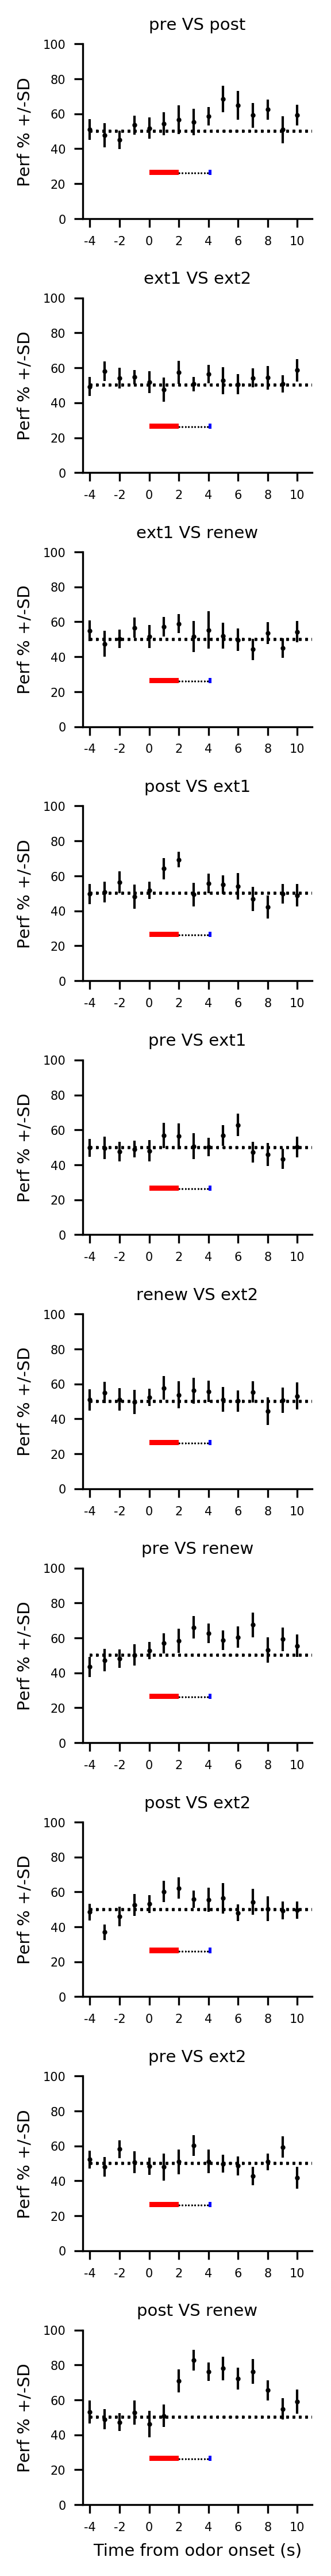

In [34]:
#across session only
fig, ax = pl.subplots(10,1, figsize=(2, 15))
across=[]
for x in [2,7,12,13,18,20,23,27,28,29]:
    across.append(eval("S%s_E%s_testy.keys()[x]"%('80','120')))
for i,t in zip(range(len(across)),across):
    for r in range(16):
        ax[i].plot(r-5, np.mean(eval("S%s_E%s_testy[t][r][r]"%('80','120')))*100, 'o', color='k', ls='-',lw=.5, zorder=19 ,ms=1)
        m = np.mean(eval("S%s_E%s_testy[t][r][r]"%('80','120')))*100
        s = np.std(eval("S%s_E%s_testy[t][r][r]"%('80','120')))*100
        ax[i].errorbar(r-5, m, s, lw=0, zorder=0, color= 'k', elinewidth=1)
        ax[i].set_ylim(0, 100)
        ax[i].set_xlim(-4.5, 11)
        ax[i].set_xticks(np.arange(-4,11, 2))
        ax[i].set_xticklabels(np.arange(-4,11, 2))
        ax[i].hlines(50, -4,11, color='k', lw=1, linestyles='dotted')
        ax[i].set_ylabel('Perf % +/-SD')
        pt.plot_period_bar(ax[i], 25, start_end=(0, 2), color='r', delta_y=3)
        # pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
        pt.plot_period_bar(ax[i], 25, start_end=(4, 4.2), color='b', delta_y=3)
        ax[i].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
        ax[i].set_title((t.split("_")[-2])+" VS "+(t.split("_")[-1]))
ax[i].set_xlabel('Time from odor onset (s)')


fig.tight_layout(pad=2)

fig.savefig('../img/%s_across_tb_matched_trials80-120.jpg'%NOTEBOOK_NAME)

In [35]:
for t in range (16):
    for s,e in zip(start_trials,end_trials):
        exec('S%s_E%s_testy_means%s = {}'%(s,e,t))
    
for i in range(0,len(AC),2):
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_testy_means%s['%s_%s_%s'] = []"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_testy_means%s['%s_%s_%s']"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1])).insert(c,(eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,AC[i].split('_')[0],
                            AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c)).mean(1)).mean())

for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_testy_means%s['%s_%s_%s'] = []"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_testy_means%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1])).insert(c,eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,comp.split('_')[0],
                            comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c)).mean(1).mean())

In [36]:
#and now replace within-session score from above with score where test and train data are taken from different bins
for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            eval("S%s_E%s_testy_means%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],
                                    comp.split('_')[-1]))[t] = eval('S%s_E%s_scores_win_%s_%s_tb%s_VS_%s_%s_tb%s.mean(1).mean()'%(s,e,comp.split('_')[0],
                                    comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],t))

In [37]:
#now put all time bins into a single dict
for s,e in zip(start_trials,end_trials):
    exec("S%s_E%s_testy_means={}"%(s,e))
    for i in eval("S%s_E%s_testy_means0"%(s,e)):
        exec("S%s_E%s_testy_means[i]=[]"%(s,e))
        for r in range(len(eval("S%s_E%s_testy_means0[i]"%(s,e)))):
            exec("S%s_E%s_testy[i].append(S%s_E%s_testy_means%s[i])"%(s,e,s,e,r))
        exec("np.array([S%s_E%s_testy_means[i]])"%(s,e))


In [38]:
## this isn't working
#fig, ax = pl.subplots(len(S0_E40_testy), 1, figsize=(3,60))#, sharex=True, sharey=True)
#vmin=0.5
#vmax=1
#
##for i,t in zip(range(len(testy)),testy):
##    im = ax[i].imshow(testy_means[t],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
##    ax[i].set_title(t)
#
#for i,t in zip(range(len(S0_E40_testy)),S0_E40_testy):
#    im = ax[i].imshow(S0_E40_testy_means[t],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#    ax[i].set_title(t)
#for x in range(len(S0_E40_testy)):
#    ax[x].set_xticks(range(16))
#    ax[x].set_yticks(range(16))
#    ax[x].set_ylim(2.5, 14.5)
#    ax[x].set_xlim(2.5,14.5)
#    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0\nCS','1\nCS','2\nTr','3\nTr','4\nRw','5', '6','7','8','9','10'],fontsize=4)
#    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','CS 0','CS 1','Tr 2','Tr 3','Rw 4','5', '6','7','8','9','10'],fontsize=4)
#    ax[x].set_ylabel('Time(s) from CS onset', fontsize=5)
#    ax[x].set_xlabel('Time(s) from CS onset', fontsize=5)
#    
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
#fig.colorbar(im, cax=cax)
#fig.tight_layout(pad=2.5)
##fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)

# now, use distinct trials for train and test for decoding across time bins

In [39]:
#trying to use different trials for different time bins
from sklearn.svm import SVC
decoder = SVC(kernel='linear', decision_function_shape='ovo')

def do_test_cross_distinct(patterns_t, labels_t, patterns_T, labels_T, n_cells=None):
    which_train = {}
    which_test = {}
    for ani in patterns_t.keys():
        which_train_a = np.random.permutation(np.where(labels_t[ani]==0)[0])
        which_test_a = which_train_a[:len(which_train_a)/2]
        which_train_a = which_train_a[len(which_train_a)/2:]
        
        which_train_b = np.random.permutation(np.where(labels_t[ani]==1)[0])
        which_test_b = which_train_b[:len(which_train_b)/2]
        which_train_b = which_train_b[len(which_train_b)/2:]
        
        which_train[ani] = np.concatenate((which_train_a, which_train_b))
        which_test[ani] = np.concatenate((which_test_a, which_test_b))
    patterns_dt = patterns_t.copy()
    labels_dt = labels_t.copy()
    patterns_dT = patterns_T.copy()
    labels_dT = labels_T.copy()
    for ani in patterns_t.keys():
        patterns_dt[ani] = patterns_dt[ani][which_train[ani]]
        labels_dt[ani] = labels_dt[ani][which_train[ani]]
        patterns_dT[ani] = patterns_dT[ani][which_test[ani]]
        labels_dT[ani] = labels_dT[ani][which_test[ani]]      
        
    patterns_comb_train, labels_comb = ut.combine_patterns(patterns_dt, labels_dt)
    patterns_comb_test, labels_comb = ut.combine_patterns(patterns_dT, labels_dT)
    
    if n_cells is None:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    elif n_cells > patterns_comb_train.shape[1]:
        cells = list(range(patterns_comb_train.shape[1]))
        print len(cells),
    else:
        cells = np.random.choice(range(patterns_comb_train.shape[1]), size=n_cells, replace=False)
        #print cells.shape,
    
    decoder.fit(patterns_comb_train[:, cells], labels_comb)
    scores = decoder.score(patterns_comb_test[:, cells], labels_comb)
    decoder.fit(patterns_comb_test[:, cells], labels_comb)
    return np.append(scores, decoder.score(patterns_comb_train[:, cells], labels_comb))

In [40]:
%%time
#test across (and within) time bins within a session
n_loops=20
for s,e in zip(start_trials,end_trials):
    for comp in all_comparisons:
        for t in range (16):
            for c in range (16):
                exec('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s = {}'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c))
                exec('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s = np.r_[[do_test_cross_distinct(S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,n_cells=n_cells)\
                for r in range(n_loops)]]'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c,
                                            s,e,comp,t,s,e,comp.split('_')[0],comp.split('_')[-1],s,e,comp,c,s,e,comp.split('_')[0],comp.split('_')[-1]))
        print 'S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s DONE!'%(s,e,comp.split('_')[0],comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c),

S0_E40_scores_distinct_prepost_pre_tb15_VS_prepost_pre_tb15 DONE! S0_E40_scores_distinct_prepost_post_tb15_VS_prepost_post_tb15 DONE! S0_E40_scores_distinct_preext1_pre_tb15_VS_preext1_pre_tb15 DONE! S0_E40_scores_distinct_preext1_ext1_tb15_VS_preext1_ext1_tb15 DONE! S0_E40_scores_distinct_preext2_pre_tb15_VS_preext2_pre_tb15 DONE! S0_E40_scores_distinct_preext2_ext2_tb15_VS_preext2_ext2_tb15 DONE! S0_E40_scores_distinct_prerenew_pre_tb15_VS_prerenew_pre_tb15 DONE! S0_E40_scores_distinct_prerenew_renew_tb15_VS_prerenew_renew_tb15 DONE! S0_E40_scores_distinct_postext1_post_tb15_VS_postext1_post_tb15 DONE! S0_E40_scores_distinct_postext1_ext1_tb15_VS_postext1_ext1_tb15 DONE! S0_E40_scores_distinct_postext2_post_tb15_VS_postext2_post_tb15 DONE! S0_E40_scores_distinct_postext2_ext2_tb15_VS_postext2_ext2_tb15 DONE! S0_E40_scores_distinct_postrenew_post_tb15_VS_postrenew_post_tb15 DONE! S0_E40_scores_distinct_postrenew_renew_tb15_VS_postrenew_renew_tb15 DONE! S0_E40_scores_distinct_ext1ext2_

In [44]:
%%time
#test across session pairs
n_loops=20
for s,e in zip(start_trials,end_trials):
    AC = all_comparisons
    for i in range(0,len(AC),2):
        for t in range (16):
            for c in range (16):
                exec('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s = {}'%(s,e,AC[i].split('_')[0],AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c))
                exec('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s = np.r_[[do_test_cross_distinct(S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,S%s_E%s_%s_tb_%s,S%s_E%s_%s_labels_%s,n_cells=n_cells)\
                for r in range(n_loops)]]'%(s,e,AC[i].split('_')[0],AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c,
                                            s,e,AC[i],t,s,e,AC[i].split('_')[0],AC[i].split('_')[-1],s,e,AC[i+1],c,s,e,AC[i+1].split('_')[0],AC[i+1].split('_')[-1]))

CPU times: user 1h 27min 9s, sys: 5.88 s, total: 1h 27min 15s
Wall time: 1h 27min 8s


In [45]:
# for each time bin, collect scores from diff comparisons into a single dictionary
for t in range (16):
    for s,e in zip(start_trials,end_trials):
        exec('S%s_E%s_distinct%s = {}'%(s,e,t))
    
for i in range(0,len(AC),2):
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_distinct%s['%s_%s_%s'] = []"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_distinct%s['%s_%s_%s']"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1])).insert(c,(eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,AC[i].split('_')[0],
                            AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c))))

for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_distinct%s['%s_%s_%s'] = []"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_distinct%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1])).insert(c,(eval('S%s_E%s_scores_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,comp.split('_')[0],
                            comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c))))

In [46]:
#get mean of each loop (not overall mean, which we will do below). TrainTest mean.
for t in range(16):
    for s,e in zip(start_trials,end_trials):
        exec("S%s_E%s_TrTe_mean_distinct%s = {}"%(s,e,t))
        for i in eval("S%s_E%s_distinct%s"%(s,e,t)):
            exec("S%s_E%s_TrTe_mean_distinct%s[i] = [[] for x in range(len(S%s_E%s_distinct%s[i]))]"%(s,e,t,s,e,t)) #initialize list of lists with proper # of entries
            for r in range(len(eval("S%s_E%s_distinct%s[i]"%(s,e,t)))):
                exec("S%s_E%s_TrTe_mean_distinct%s[i][r].append([S%s_E%s_distinct%s[i][r][x].mean() for x in range(len(S%s_E%s_distinct%s[i][r]))])"%(s,e,t,s,e,t,s,e,t))
                exec("S%s_E%s_TrTe_mean_distinct%s[i][r] = S%s_E%s_TrTe_mean_distinct%s[i][r][0]"%(s,e,t,s,e,t)) # get rid of outer list encasing list

In [50]:
#perform wilcoxon test (nonparametric) for each decoding epoch vs chance (.5)
for t in range(16):
    for s,e in zip(start_trials,end_trials):
        exec("S%s_E%s_distinct%s_wilcox = {}"%(s,e,t))
        for i in eval("S%s_E%s_TrTe_mean_distinct%s"%(s,e,t)):
            exec("S%s_E%s_distinct%s_wilcox[i] = [[] for x in range(len(S%s_E%s_distinct%s[i]))]"%(s,e,t,s,e,t)) #initialize list of lists with proper # of entries
            for r in range(len(eval("S%s_E%s_TrTe_mean_distinct%s[i]"%(s,e,t)))):
                exec("subtracted = [x-0.5 for x in S%s_E%s_TrTe_mean_distinct%s[i][r]]"%(s,e,t))
                exec("S%s_E%s_distinct%s_wilcox[i][r] =  sstats.wilcoxon(subtracted[:15])"%(s,e,t))
                exec("S%s_E%s_distinct%s_wilcox[i][r] = S%s_E%s_distinct%s_wilcox[i][r][-1]"%(s,e,t,s,e,t)) #only take p-values

In [51]:
#now put all time bins into a single dict
for s,e in zip(start_trials,end_trials):
    exec("S%s_E%s_distinct={}"%(s,e))
    for i in eval("S%s_E%s_distinct0"%(s,e)):
        exec("S%s_E%s_distinct[i]=[]"%(s,e))
        for r in range(len(eval("S%s_E%s_distinct0[i]"%(s,e)))):
            exec("S%s_E%s_distinct[i].append(S%s_E%s_distinct%s[i])"%(s,e,s,e,r))
        exec("np.array([S%s_E%s_distinct[i]])"%(s,e))

In [52]:
for t in range (16):
    for s,e in zip(start_trials,end_trials):
        exec('S%s_E%s_distinct_means%s = {}'%(s,e,t))
    
for i in range(0,len(AC),2):
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_distinct_means%s['%s_%s_%s'] = []"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_distinct_means%s['%s_%s_%s']"%(s,e,t,AC[i].split('_')[0],AC[i].split('_')[-1],AC[i+1].split('_')[-1])).insert(c,(eval('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,AC[i].split('_')[0],
                            AC[i].split('_')[-1],t,AC[i+1].split('_')[0],AC[i+1].split('_')[-1],c)).mean(1)).mean())

for comp in all_comparisons:
    for t in range (16):
        for s,e in zip(start_trials,end_trials):
            exec("S%s_E%s_distinct_means%s['%s_%s_%s'] = []"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1]))
            for c in range (16):
                eval("S%s_E%s_distinct_means%s['%s_%s_%s']"%(s,e,t,comp.split('_')[0],comp.split('_')[-1],comp.split('_')[-1])).insert(c,eval('S%s_E%s_scores_distinct_%s_%s_tb%s_VS_%s_%s_tb%s'%(s,e,comp.split('_')[0],
                            comp.split('_')[-1],t,comp.split('_')[0],comp.split('_')[-1],c)).mean(1).mean())

In [53]:
#now put all time bins into a single dict
for s,e in zip(start_trials,end_trials):
    exec("S%s_E%s_distinct_means={}"%(s,e))
    for i in eval("S%s_E%s_distinct_means0"%(s,e)):
        exec("S%s_E%s_distinct_means[i]=[]"%(s,e))
        for r in range(len(eval("S%s_E%s_distinct_means0[i]"%(s,e)))):
            exec("S%s_E%s_distinct[i].append(S%s_E%s_distinct_means%s[i])"%(s,e,s,e,r))
        exec("np.array([S%s_E%s_distinct_means[i]])"%(s,e))


In [54]:
## this isn't working
#fig, ax = pl.subplots(len(S0_E40_distinct_means), 1, figsize=(3,60))#, sharex=True, sharey=True)
#vmin=0.5
#vmax=1
#for i,t in zip(range(len(S0_E40_distinct_means)),S0_E40_distinct_means):
#    im = ax[i].imshow(S0_E40_distinct_means[t],origin='lower', interpolation='nearest',vmin=vmin, vmax=vmax)
#    ax[i].set_title(t)
#
#for x in range(len(testy)):
#    ax[x].set_xticks(range(16))
#    ax[x].set_yticks(range(16))
#    #ax[x].set_ylim(2.5, 14.5)
#    #ax[x].set_xlim(2.5,14.5)
#    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0\nCS','1\nCS','2\nTr','3\nTr','4\nRw','5', '6','7','8','9','10'],fontsize=4)
#    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','CS 0','CS 1','Tr 2','Tr 3','Rw 4','5', '6','7','8','9','10'],fontsize=4)
#    ax[x].set_ylabel('Time(s) from CS onset', fontsize=5)
#    ax[x].set_xlabel('Time(s) from CS onset', fontsize=5)
#
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
#fig.colorbar(im, cax=cax)
#fig.tight_layout(pad=2.5)
##fig.savefig('../img/%s.jpg'%NOTEBOOK_NAME)

In [55]:
mega_list_col1 = ['prepost_pre_pre'],['prepost_pre_post'],['preext1_pre_ext1'],['preext2_pre_ext2'],['prerenew_pre_renew']
mega_list_col2 = ['prepost_pre_post'],['postrenew_post_post'],['postext1_post_ext1'],['postext2_post_ext2'],['postrenew_post_renew']
mega_list_col3 = ['preext1_pre_ext1'],['postext1_post_ext1'],['postext1_ext1_ext1'],['ext1ext2_ext1_ext2'],['ext1renew_ext1_renew']
mega_list_col4 = ['preext2_pre_ext2'],['postext2_post_ext2'],['ext1ext2_ext1_ext2'],['ext1ext2_ext2_ext2'],['ext2renew_renew_ext2']
mega_list_col5 = ['prerenew_pre_renew'],['postrenew_post_renew'],['ext1renew_ext1_renew'],['ext2renew_renew_ext2'],['postrenew_renew_renew']

In [56]:
for col in range(1,6):
    exec("S0_E40_mega_col%s = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]"%(col))
    for x in range(len(S0_E40_distinct_means0['ext1ext2_ext1_ext1'])):
        exec("S0_E40_mega_col%s[%s] = []"%(col,x))
        for c in range(len(mega_list_col1)):
            for comp in eval("mega_list_col%s[%s]"%((c+1),col-1)):
                for y in range(len(S0_E40_distinct_means0['ext1ext2_ext1_ext1'])):
                    print col,x,c,comp,y,'ok',
                    eval("S0_E40_mega_col%s[x]"%(col)).insert((16*c)+y, eval("S0_E40_distinct_means%s[comp][y]"%(x)))

1 0 0 prepost_pre_pre 0 ok 1 0 0 prepost_pre_pre 1 ok 1 0 0 prepost_pre_pre 2 ok 1 0 0 prepost_pre_pre 3 ok 1 0 0 prepost_pre_pre 4 ok 1 0 0 prepost_pre_pre 5 ok 1 0 0 prepost_pre_pre 6 ok 1 0 0 prepost_pre_pre 7 ok 1 0 0 prepost_pre_pre 8 ok 1 0 0 prepost_pre_pre 9 ok 1 0 0 prepost_pre_pre 10 ok 1 0 0 prepost_pre_pre 11 ok 1 0 0 prepost_pre_pre 12 ok 1 0 0 prepost_pre_pre 13 ok 1 0 0 prepost_pre_pre 14 ok 1 0 0 prepost_pre_pre 15 ok 1 0 1 prepost_pre_post 0 ok 1 0 1 prepost_pre_post 1 ok 1 0 1 prepost_pre_post 2 ok 1 0 1 prepost_pre_post 3 ok 1 0 1 prepost_pre_post 4 ok 1 0 1 prepost_pre_post 5 ok 1 0 1 prepost_pre_post 6 ok 1 0 1 prepost_pre_post 7 ok 1 0 1 prepost_pre_post 8 ok 1 0 1 prepost_pre_post 9 ok 1 0 1 prepost_pre_post 10 ok 1 0 1 prepost_pre_post 11 ok 1 0 1 prepost_pre_post 12 ok 1 0 1 prepost_pre_post 13 ok 1 0 1 prepost_pre_post 14 ok 1 0 1 prepost_pre_post 15 ok 1 0 2 preext1_pre_ext1 0 ok 1 0 2 preext1_pre_ext1 1 ok 1 0 2 preext1_pre_ext1 2 ok 1 0 2 preext1_pre_ext1 3

In [57]:
S0_E40_mega_distinct_means_all = S0_E40_mega_col1+S0_E40_mega_col2+S0_E40_mega_col3+S0_E40_mega_col4+S0_E40_mega_col5

In [58]:
for col in range(1,6):
    exec("S80_E120_mega_col%s = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]"%(col))
    for x in range(len(S80_E120_distinct_means0['ext1ext2_ext1_ext1'])):
        exec("S80_E120_mega_col%s[%s] = []"%(col,x))
        for c in range(len(mega_list_col1)):
            for comp in eval("mega_list_col%s[%s]"%((c+1),col-1)):
                for y in range(len(S80_E120_distinct_means0['ext1ext2_ext1_ext1'])):
                    print col,x,c,comp,y,'ok',
                    eval("S80_E120_mega_col%s[x]"%(col)).insert((16*c)+y, eval("S80_E120_distinct_means%s[comp][y]"%(x)))

1 0 0 prepost_pre_pre 0 ok 1 0 0 prepost_pre_pre 1 ok 1 0 0 prepost_pre_pre 2 ok 1 0 0 prepost_pre_pre 3 ok 1 0 0 prepost_pre_pre 4 ok 1 0 0 prepost_pre_pre 5 ok 1 0 0 prepost_pre_pre 6 ok 1 0 0 prepost_pre_pre 7 ok 1 0 0 prepost_pre_pre 8 ok 1 0 0 prepost_pre_pre 9 ok 1 0 0 prepost_pre_pre 10 ok 1 0 0 prepost_pre_pre 11 ok 1 0 0 prepost_pre_pre 12 ok 1 0 0 prepost_pre_pre 13 ok 1 0 0 prepost_pre_pre 14 ok 1 0 0 prepost_pre_pre 15 ok 1 0 1 prepost_pre_post 0 ok 1 0 1 prepost_pre_post 1 ok 1 0 1 prepost_pre_post 2 ok 1 0 1 prepost_pre_post 3 ok 1 0 1 prepost_pre_post 4 ok 1 0 1 prepost_pre_post 5 ok 1 0 1 prepost_pre_post 6 ok 1 0 1 prepost_pre_post 7 ok 1 0 1 prepost_pre_post 8 ok 1 0 1 prepost_pre_post 9 ok 1 0 1 prepost_pre_post 10 ok 1 0 1 prepost_pre_post 11 ok 1 0 1 prepost_pre_post 12 ok 1 0 1 prepost_pre_post 13 ok 1 0 1 prepost_pre_post 14 ok 1 0 1 prepost_pre_post 15 ok 1 0 2 preext1_pre_ext1 0 ok 1 0 2 preext1_pre_ext1 1 ok 1 0 2 preext1_pre_ext1 2 ok 1 0 2 preext1_pre_ext1 3

In [59]:
S80_E120_mega_distinct_means_all = S80_E120_mega_col1+S80_E120_mega_col2+S80_E120_mega_col3+S80_E120_mega_col4+S80_E120_mega_col5

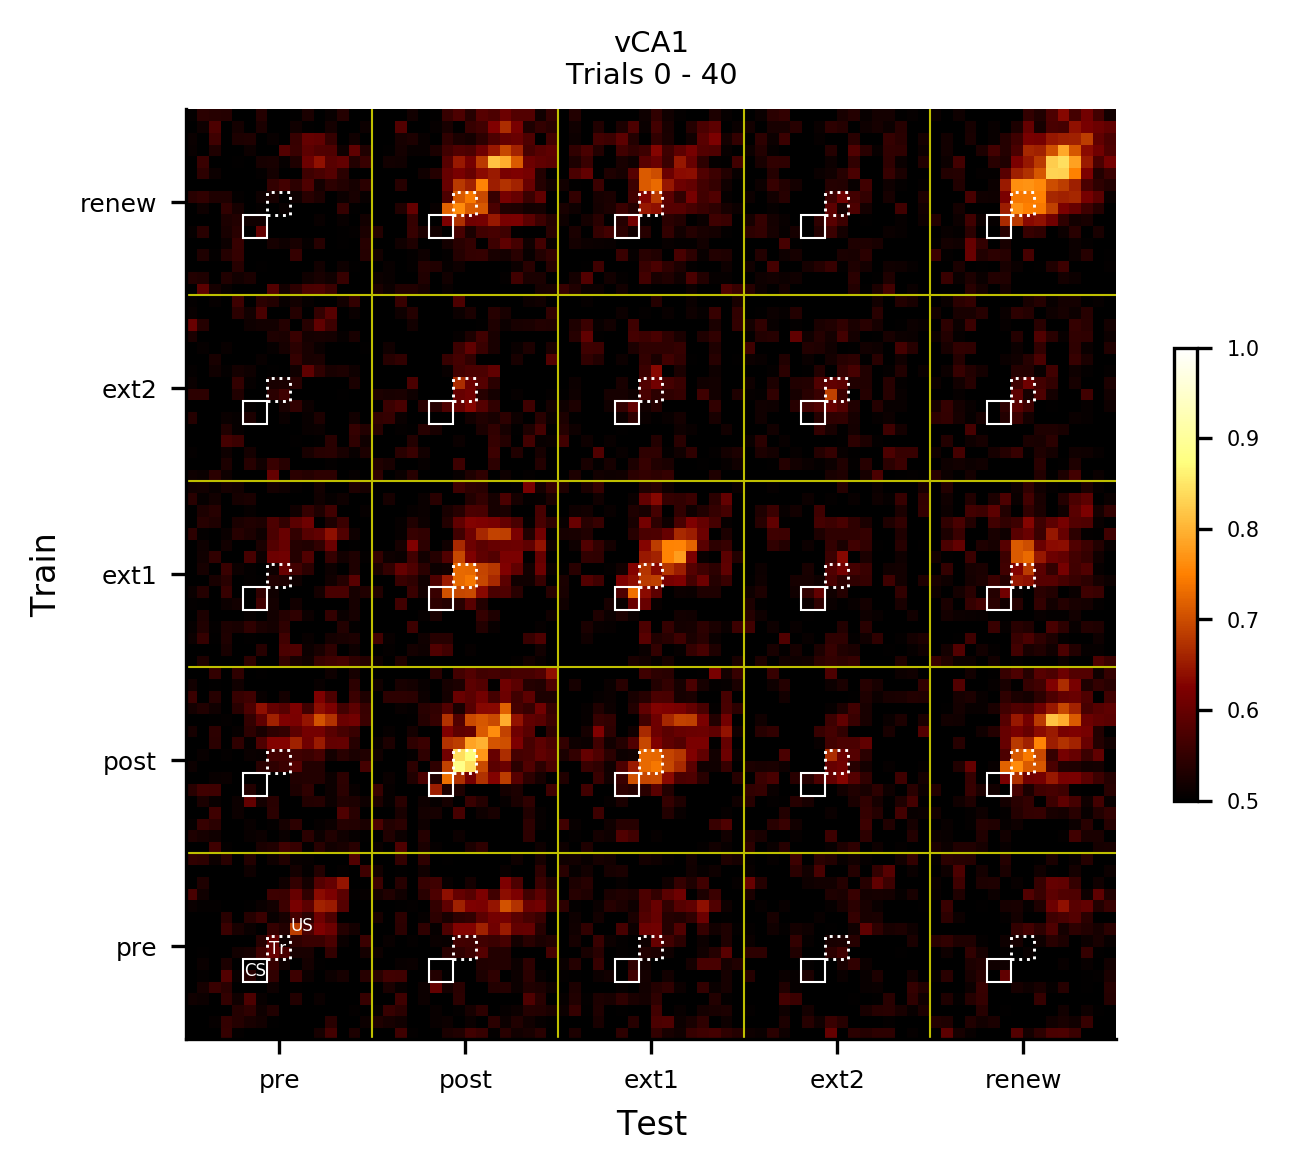

In [60]:
fig,ax = pl.subplots(1,figsize=(5,5))
im = ax.pcolormesh(S0_E40_mega_distinct_means_all,vmin=0.5, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40,56,72]
ax.set_xticks(ticks)
#ax.set_xticks((6,22,38,54,70),minor=True)
ax.set_yticks(ticks)
#ax.set_yticks((6,22,38,54,70),minor=True)
#ax.set_ylim(0,85)
#ax.set_xlim(0,85)
ax.set_xticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_yticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_ylabel('Train', fontsize=8)
ax.set_xlabel('Test', fontsize=8)
pl.hlines([16,32,48,64],-0.5,80,color='y')
pl.vlines([16,32,48,64],-0.5,80,color='y')
##pl.vlines(2,-0.5,2,color='pink')
##pl.hlines(2,-0.5,2,color='pink')
pl.title('vCA1\nTrials 0 - 40')
#pl.text(2,2,"CS",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(3,3,"Tr",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(4,4,"US",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS4 = patches.Rectangle((i*16+4.9,3*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS5 = patches.Rectangle((i*16+4.9,4*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr4 = patches.Rectangle((i*16+6.9,3*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr5 = patches.Rectangle((i*16+6.9,4*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(CS4)
    ax.add_patch(CS5)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
    ax.add_patch(Tr4)
    ax.add_patch(Tr5)

pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')

#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../img/%s_MEGA_MATRIX_trials0-40.pdf'%NOTEBOOK_NAME)

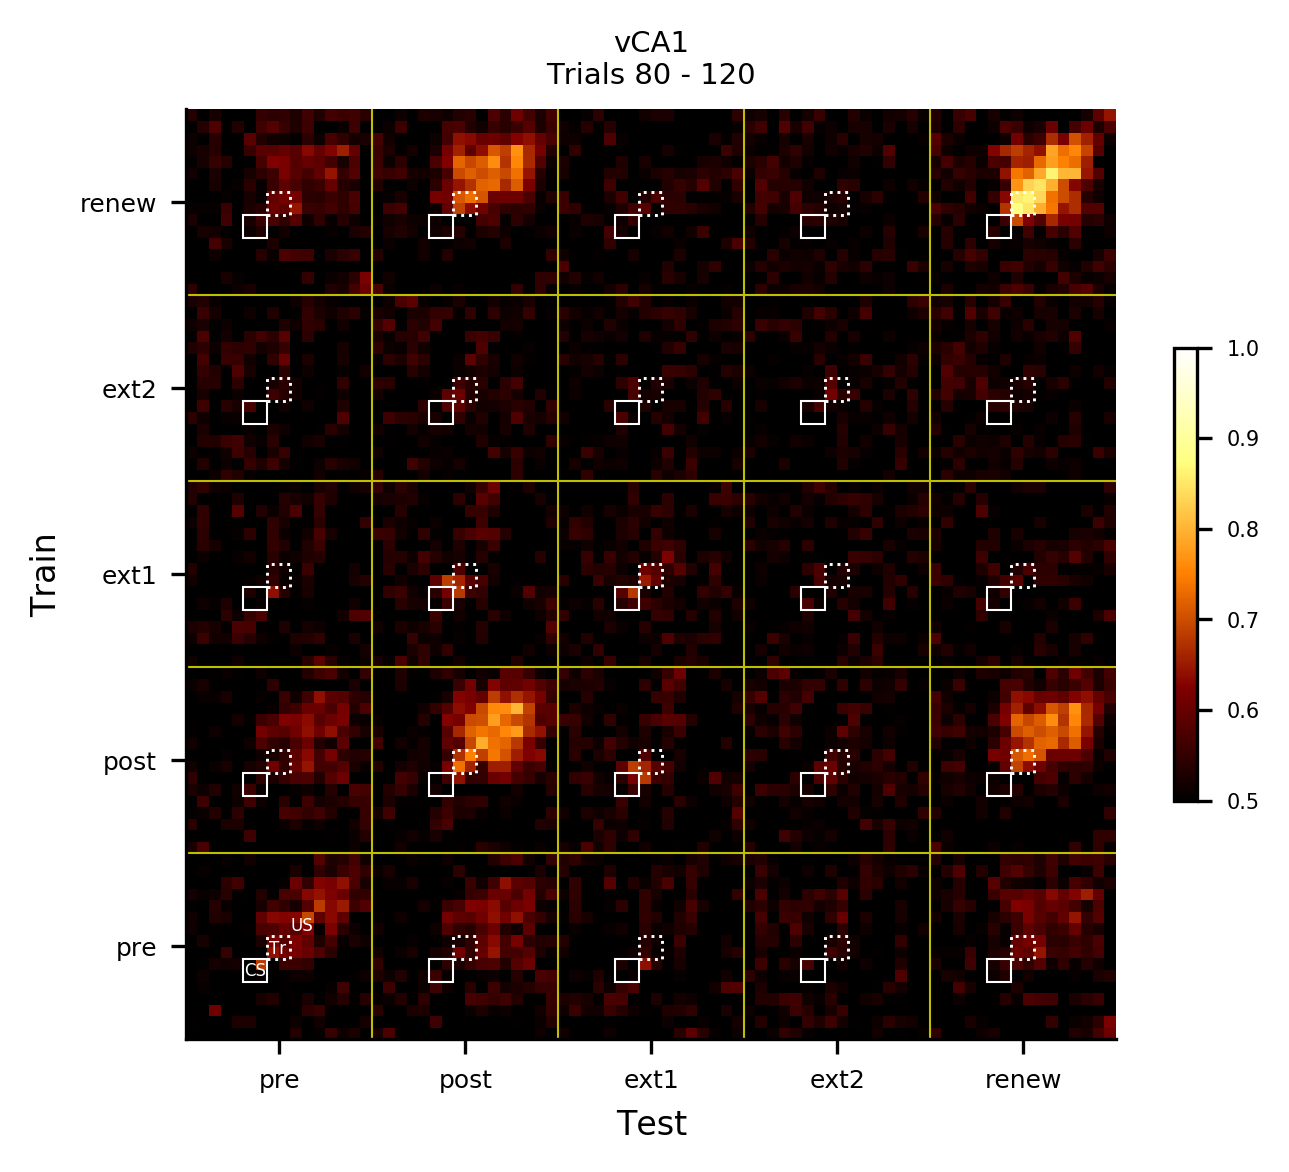

In [61]:
fig,ax = pl.subplots(1,figsize=(5,5))
im = ax.pcolormesh(S80_E120_mega_distinct_means_all,vmin=0.5, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40,56,72]
ax.set_xticks(ticks)
#ax.set_xticks((6,22,38,54,70),minor=True)
ax.set_yticks(ticks)
#ax.set_yticks((6,22,38,54,70),minor=True)
#ax.set_ylim(0,85)
#ax.set_xlim(0,85)
ax.set_xticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_yticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_ylabel('Train', fontsize=8)
ax.set_xlabel('Test', fontsize=8)
pl.hlines([16,32,48,64],-0.5,80,color='y')
pl.vlines([16,32,48,64],-0.5,80,color='y')
##pl.vlines(2,-0.5,2,color='pink')
##pl.hlines(2,-0.5,2,color='pink')
pl.title('vCA1\nTrials 80 - 120')
#pl.text(2,2,"CS",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(3,3,"Tr",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(4,4,"US",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS4 = patches.Rectangle((i*16+4.9,3*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS5 = patches.Rectangle((i*16+4.9,4*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr4 = patches.Rectangle((i*16+6.9,3*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr5 = patches.Rectangle((i*16+6.9,4*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(CS4)
    ax.add_patch(CS5)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
    ax.add_patch(Tr4)
    ax.add_patch(Tr5)

pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')

#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../img/%s_MEGA_MATRIX_trials80-120.pdf'%NOTEBOOK_NAME)

In [63]:
for col in range(1,6):
    exec("S0_E40_mega_pval_col%s = [[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]]"%(col))
    for x in range(len(S0_E40_distinct0_wilcox['ext1ext2_ext1_ext1'])):
        exec("S0_E40_mega_pval_col%s[%s] = []"%(col,x))
        for c in range(len(mega_list_col1)):
            for comp in eval("mega_list_col%s[%s]"%((c+1),col-1)):
                for y in range(len(S0_E40_distinct0_wilcox['ext1ext2_ext1_ext1'])):
                    print col,x,c,comp,y,'ok',
                    eval("S0_E40_mega_pval_col%s[x]"%(col)).insert((16*c)+y, eval("S0_E40_distinct%s_wilcox[comp][y]"%(x)))

 1 0 0 prepost_pre_pre 0 ok 1 0 0 prepost_pre_pre 1 ok 1 0 0 prepost_pre_pre 2 ok 1 0 0 prepost_pre_pre 3 ok 1 0 0 prepost_pre_pre 4 ok 1 0 0 prepost_pre_pre 5 ok 1 0 0 prepost_pre_pre 6 ok 1 0 0 prepost_pre_pre 7 ok 1 0 0 prepost_pre_pre 8 ok 1 0 0 prepost_pre_pre 9 ok 1 0 0 prepost_pre_pre 10 ok 1 0 0 prepost_pre_pre 11 ok 1 0 0 prepost_pre_pre 12 ok 1 0 0 prepost_pre_pre 13 ok 1 0 0 prepost_pre_pre 14 ok 1 0 0 prepost_pre_pre 15 ok 1 0 1 prepost_pre_post 0 ok 1 0 1 prepost_pre_post 1 ok 1 0 1 prepost_pre_post 2 ok 1 0 1 prepost_pre_post 3 ok 1 0 1 prepost_pre_post 4 ok 1 0 1 prepost_pre_post 5 ok 1 0 1 prepost_pre_post 6 ok 1 0 1 prepost_pre_post 7 ok 1 0 1 prepost_pre_post 8 ok 1 0 1 prepost_pre_post 9 ok 1 0 1 prepost_pre_post 10 ok 1 0 1 prepost_pre_post 11 ok 1 0 1 prepost_pre_post 12 ok 1 0 1 prepost_pre_post 13 ok 1 0 1 prepost_pre_post 14 ok 1 0 1 prepost_pre_post 15 ok 1 0 2 preext1_pre_ext1 0 ok 1 0 2 preext1_pre_ext1 1 ok 1 0 2 preext1_pre_ext1 2 ok 1 0 2 preext1_pre_ext1 

In [64]:
S0_E40_mega_distinct_pval_all = S0_E40_mega_pval_col1+S0_E40_mega_pval_col2+S0_E40_mega_pval_col3+S0_E40_mega_pval_col4+S0_E40_mega_pval_col5

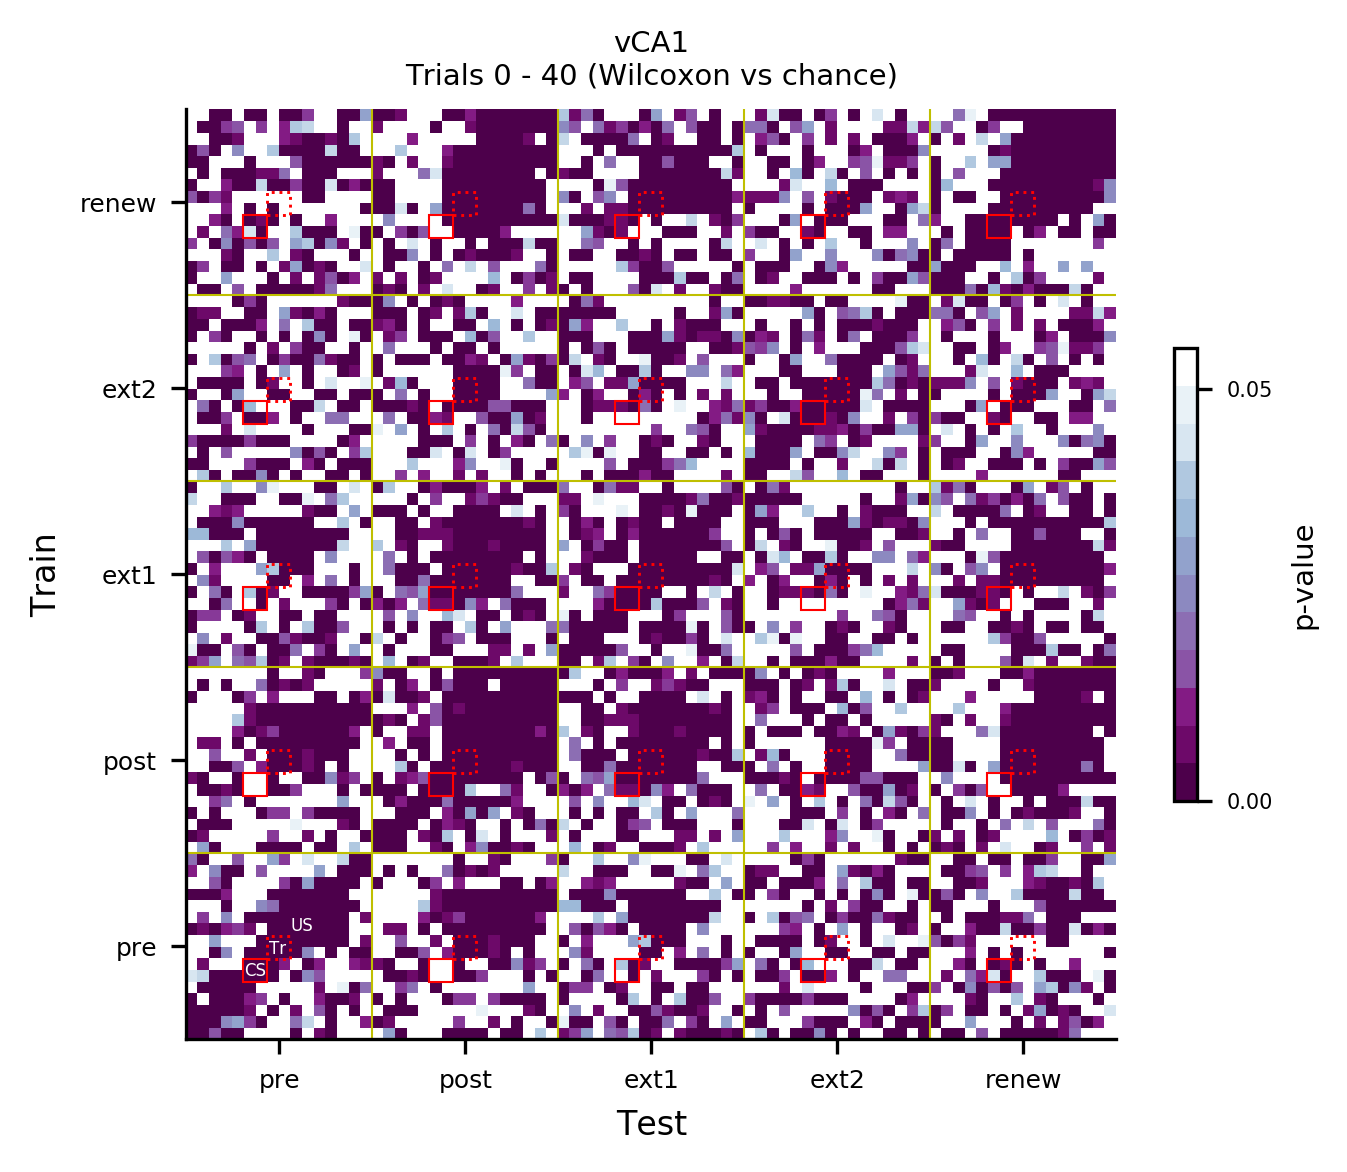

In [65]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 53)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 14)),
                       sigs(np.linspace(0, 1, 242))))
#pink = np.array([.96, .09, .6, 1])
newcolors[13:, :] = white
newcmp = ListedColormap(newcolors)

fig,ax = pl.subplots(1,figsize=(5,5))
im = ax.pcolormesh(S0_E40_mega_distinct_pval_all,vmin=0, vmax=1,cmap=newcmp)
pl.axis('image')
ticks = [8,24,40,56,72]
ax.set_xticks(ticks)
#ax.set_xticks((6,22,38,54,70),minor=True)
ax.set_yticks(ticks)
#ax.set_yticks((6,22,38,54,70),minor=True)
#ax.set_ylim(0,85)
#ax.set_xlim(0,85)
ax.set_xticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_yticklabels(['pre','post','ext1','ext2','renew'],fontsize=6)
ax.set_ylabel('Train', fontsize=8)
ax.set_xlabel('Test', fontsize=8)
pl.hlines([16,32,48,64],-0.5,80,color='y')
pl.vlines([16,32,48,64],-0.5,80,color='y')
##pl.vlines(2,-0.5,2,color='pink')
##pl.hlines(2,-0.5,2,color='pink')
pl.title('vCA1\nTrials 0 - 40 (Wilcoxon vs chance)')
#pl.text(2,2,"CS",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(3,3,"Tr",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')
#pl.text(4,4,"US",fontsize=2,color='white',horizontalalignment='center',verticalalignment='center')

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='r',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='r',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='r',facecolor='none')
    CS4 = patches.Rectangle((i*16+4.9,3*16+4.9),2,2,linewidth=.5,edgecolor='r',facecolor='none')
    CS5 = patches.Rectangle((i*16+4.9,4*16+4.9),2,2,linewidth=.5,edgecolor='r',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='r',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='r',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='r',facecolor='none',linestyle=':')
    Tr4 = patches.Rectangle((i*16+6.9,3*16+6.9),2,2,linewidth=.7,edgecolor='r',facecolor='none',linestyle=':')
    Tr5 = patches.Rectangle((i*16+6.9,4*16+6.9),2,2,linewidth=.7,edgecolor='r',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(CS4)
    ax.add_patch(CS5)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
    ax.add_patch(Tr4)
    ax.add_patch(Tr5)

pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')

#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4,ticks=[0,.05,1],label='p-value',boundaries=np.linspace(0,.055,13))

fig.savefig('../img/%s_MEGA_MATRIX_pvals.pdf'%NOTEBOOK_NAME)

In [67]:
save_workspace(db)

Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'cm'. Skipping...
Could not store variable 'di'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'patches'. Skipping...
